<a href="https://colab.research.google.com/github/RavimalRanathunga/Eleczone_CNN/blob/main/CNN_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing required libraries

In [ ]:
import torch
import torchvision

###Find mean and standard deviation to Normalize the dataset

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset

transform = transforms.Compose([
    transforms.ToTensor()
])

mnist_train = torchvision.datasets.MNIST(root='./test', train=True, download=True,transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./test', train=False, download=True,transform=transform)

mnist_full_test = ConcatDataset([mnist_train, mnist_test])
print(mnist_full_test[0][0].shape)
x = torch.stack([sample[0] for sample in mnist_full_test])
print(x.shape)
mean = torch.mean(x,dim=(0,2,3))
std = torch.std(x,dim=(0,2,3))

print(mean)
print(std)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.06MB/s]


torch.Size([1, 28, 28])
torch.Size([70000, 1, 28, 28])
tensor([0.1309])
tensor([0.3084])


In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1309,), (0.3084,))
])

###Import dataset

In [ ]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.65MB/s]


In [ ]:
from torch.utils.data import ConcatDataset

mnist_full = ConcatDataset([mnist_train, mnist_test])

In [ ]:
print(f"Shape of the concatenated dataset: {len(mnist_full)}")

Shape of the concatenated dataset: 70000


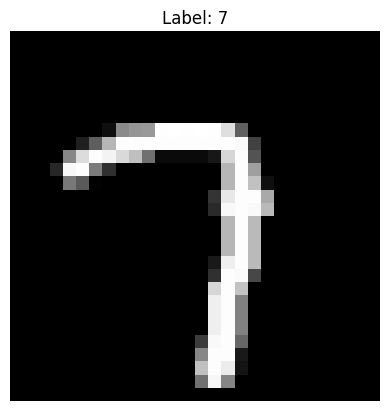

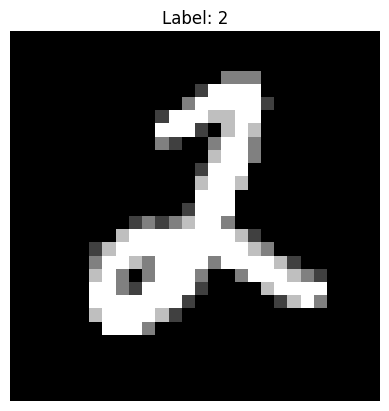

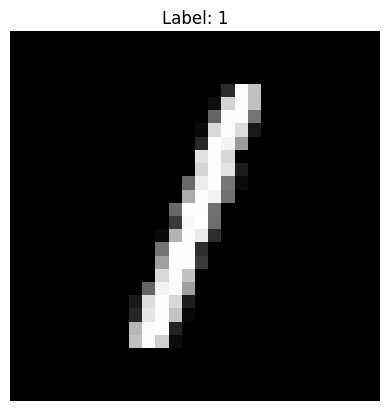

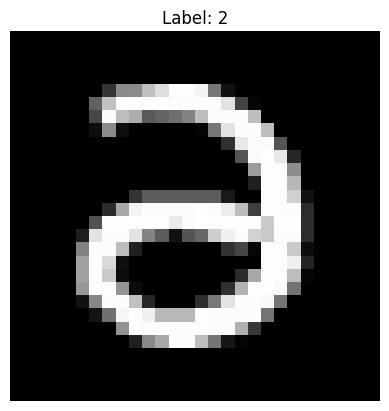

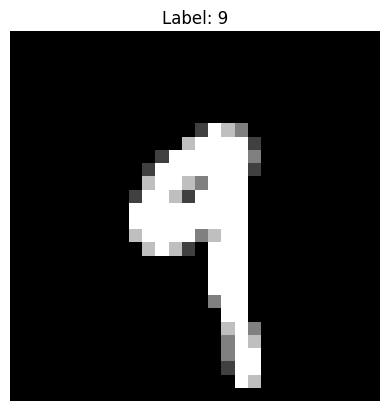

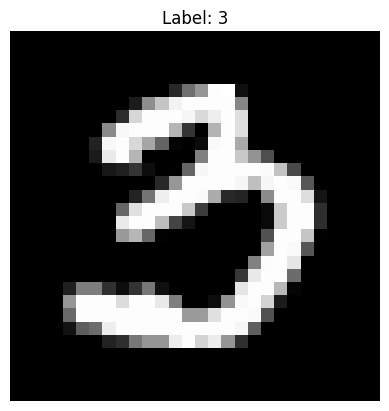

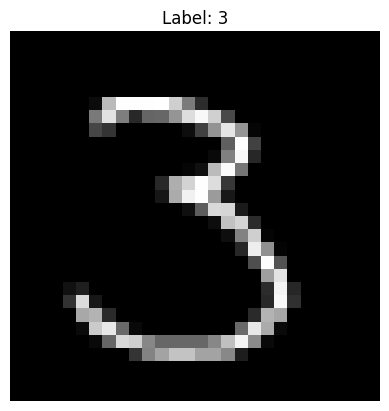

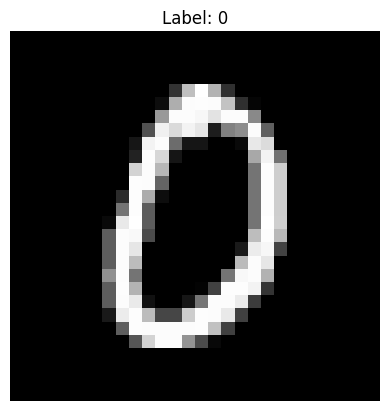

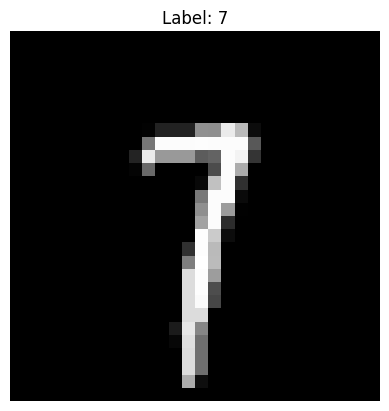

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Display some random samples
num_samples = 9  # You can change this number

for i in range(num_samples):
    # Get a random index
    random_index = random.randint(0, len(mnist_full) - 1)
    image, label = mnist_full[random_index]

    # Apply the transform to convert the PIL Image to a tensor and normalize
    image = transform(image)

    # Display the image
    plt.figure()  # Create a new figure for each image
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

In [ ]:
from collections import Counter

# Get all the labels from the dataset
all_labels = [label for _, label in mnist_full]

# Count the occurrences of each label
label_counts = Counter(all_labels)

# Print the counts for each class
for label, count in label_counts.items():
    print(f"Class {label}: {count} instances")

Class 5: 6313 instances
Class 0: 6903 instances
Class 4: 6824 instances
Class 1: 7877 instances
Class 9: 6958 instances
Class 2: 6990 instances
Class 3: 7141 instances
Class 6: 6876 instances
Class 7: 7293 instances
Class 8: 6825 instances


###Train, Validation and Test split

In [ ]:
from torch.utils.data import random_split

# Define the split sizes
total_size = len(mnist_full)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
mnist_train_split, mnist_val_split, mnist_test_split = random_split(
    mnist_full, [train_size, val_size, test_size]
)

print(f"Training set size: {len(mnist_train_split)}")
print(f"Validation set size: {len(mnist_val_split)}")
print(f"Test set size: {len(mnist_test_split)}")

Training set size: 49000
Validation set size: 10500
Test set size: 10500


###Define the Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Calculate the output size of the convolutional and pooling layers
        def _get_conv_output_size(shape):
            with torch.no_grad():
                input = torch.autograd.Variable(torch.rand(1, *shape))
                output = self.conv1(input)
                output = F.max_pool2d(output, 2)
                output = self.conv2(output)
                output = F.max_pool2d(output, 2)
                return output.data.view(1, -1).size(1)

        self.fc1 = nn.Linear(_get_conv_output_size((1, 28, 28)), 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

###Utility functions

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack([transform(img) for img in images])
    labels = torch.tensor(labels)
    return images, labels

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


###Train loader

In [ ]:
#Create a DataLoader for the training set
train_loader = DataLoader(mnist_train_split, batch_size=128, shuffle=True, collate_fn=collate_fn)

# Create a DataLoader for the validation set
val_loader = DataLoader(mnist_val_split, batch_size=128, shuffle=False, collate_fn=collate_fn)

###Training loop with Adam optimizer

Epoch [1/20], Step [100/383], Average Loss for 100 samples: 0.5996
Epoch [1/20], Step [200/383], Average Loss for 100 samples: 0.1885
Epoch [1/20], Step [300/383], Average Loss for 100 samples: 0.1416
Epoch [1/20], Training Loss: 103.9396
Epoch [1/20], Validation Loss: 6.2922, Validation Accuracy: 97.42%
Epoch [2/20], Step [100/383], Average Loss for 100 samples: 0.1076
Epoch [2/20], Step [200/383], Average Loss for 100 samples: 0.1006
Epoch [2/20], Step [300/383], Average Loss for 100 samples: 0.0925
Epoch [2/20], Training Loss: 37.1135
Epoch [2/20], Validation Loss: 4.4376, Validation Accuracy: 98.21%
Epoch [3/20], Step [100/383], Average Loss for 100 samples: 0.0709
Epoch [3/20], Step [200/383], Average Loss for 100 samples: 0.0661
Epoch [3/20], Step [300/383], Average Loss for 100 samples: 0.0769
Epoch [3/20], Training Loss: 27.6331
Epoch [3/20], Validation Loss: 3.6071, Validation Accuracy: 98.63%
Epoch [4/20], Step [100/383], Average Loss for 100 samples: 0.0571
Epoch [4/20], Ste

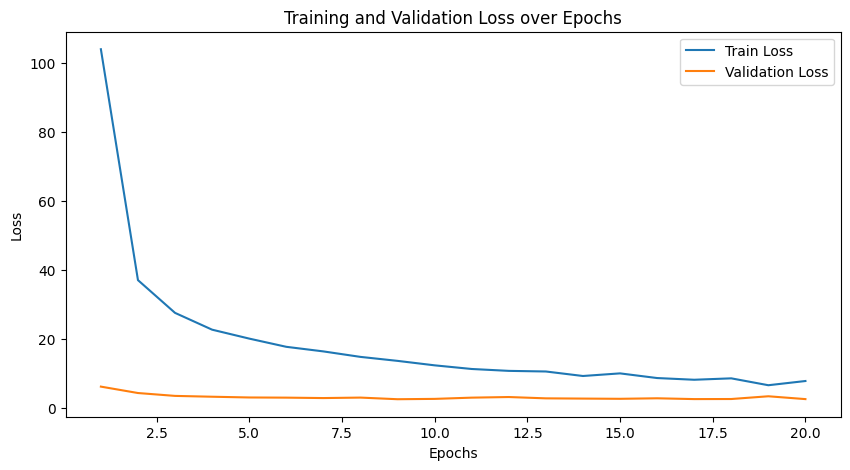

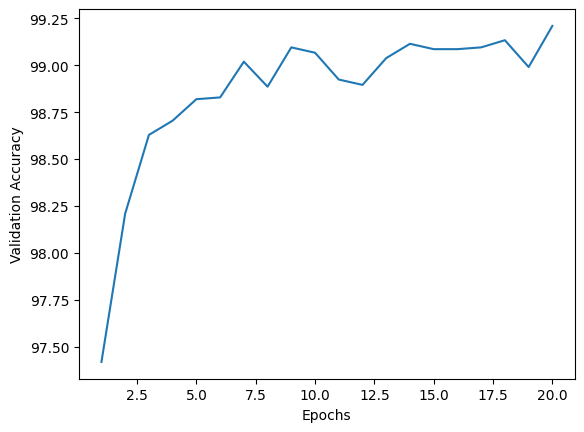

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the number of training epochs
num_epochs = 20

# Define optimizer and loss function
model = Net().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss = []
val_loss = []
val_accuracy = []
max_accuracy = 0
best_epoch = 0

# Start a loop that iterates for the specified number of epochs
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    total_train_loss = 0.0

    # Start an inner loop to iterate over the train_loader
    for i, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Perform a forward pass by passing the images through the model to get the outputs
        outputs = model(images)

        # Calculate the loss between the model's outputs and the true labels using the defined criterion
        loss = criterion(outputs, labels)

        # Perform a backward pass to compute the gradients
        loss.backward()

        # Update the model's weights using the optimizer's step function
        optimizer.step()

        # Optionally, print the loss at regular intervals (e.g., every few batches) to monitor training progress.
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss for 100 samples: {running_loss/100:.4f}")
            running_loss = 0.0
        total_train_loss+=loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_train_loss:.4f}")
    train_loss.append(total_train_loss)

    # Add validation loop after the training loop for each epoch
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if accuracy > max_accuracy:
      max_accuracy = accuracy
      best_epoch = epoch

    avg_val_loss = total_val_loss
    val_loss.append(avg_val_loss)
    val_accuracy.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")


print("Training finished.")
print("Max accuracy:", max_accuracy)
print("Best epoch:", best_epoch+1)

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

plt.plot(range(1,num_epochs + 1), val_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

### Training loop with standard SGD optimizer

In [ ]:
# Define optimizer and loss function for standard SGD
model_sgd = Net().to(device)
criterion_sgd = nn.NLLLoss()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.001)

train_loss_sgd = []
val_loss_sgd = []
val_accuracy_sgd = []
max_accuracy_sgd = 0
best_epoch_sgd = 0

# Start a loop that iterates for the specified number of epochs
for epoch in range(num_epochs):
    # Inside the epoch loop, set the model to training mode
    model_sgd.train()
    running_loss = 0.0
    total_train_loss = 0.0
    # Start an inner loop to iterate over the train_loader
    for i, (images, labels) in enumerate(train_loader):
        # Inside the batch loop, get the images and labels from the current batch and move them to the the device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer_sgd.zero_grad()

        # Perform a forward pass by passing the images through the model to get the outputs
        outputs = model_sgd(images)

        # Calculate the loss between the model's outputs and the true labels using the defined criterion
        loss = criterion_sgd(outputs, labels)

        # Perform a backward pass to compute the gradients
        loss.backward()

        # Update the model's weights using the optimizer's step function
        optimizer_sgd.step()

        # Optionally, print the loss at regular intervals (e.g., every few batches) to monitor training progress.
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss for 100 samples: {running_loss/100:.4f}")
            running_loss = 0.0
        total_train_loss+=loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_train_loss:.4f}")
    train_loss_sgd.append(total_train_loss)

    # Add validation loop after the training loop for each epoch
    model_sgd.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_sgd(images)
            loss = criterion_sgd(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if accuracy > max_accuracy_sgd:
      max_accuracy_sgd = accuracy
      best_epoch_sgd = epoch
    avg_val_loss = total_val_loss
    val_loss_sgd.append(avg_val_loss)
    val_accuracy_sgd.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Training finished with SGD.")
print("Max accuracy:", max_accuracy_sgd)
print("Best epoch:", best_epoch_sgd+1)

# Plotting Training and Validation Loss for SGD
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_sgd, label='Train Loss (SGD)')
plt.plot(range(1, num_epochs + 1), val_loss_sgd, label='Validation Loss (SGD)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs (SGD)")
plt.legend()
plt.show()

plt.plot(range(1,num_epochs + 1), val_accuracy_sgd)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (SGD)")
plt.show()

Epoch [1/20], Step [100/383], Average Loss for 100 samples: 1.8991
Epoch [1/20], Step [200/383], Average Loss for 100 samples: 1.0019
Epoch [1/20], Step [300/383], Average Loss for 100 samples: 0.7074
Epoch [1/20], Training Loss: 409.6486
Epoch [1/20], Validation Loss: 30.5990, Validation Accuracy: 89.70%
Epoch [2/20], Step [100/383], Average Loss for 100 samples: 0.4973
Epoch [2/20], Step [200/383], Average Loss for 100 samples: 0.4442
Epoch [2/20], Step [300/383], Average Loss for 100 samples: 0.3885
Epoch [2/20], Training Loss: 163.2415
Epoch [2/20], Validation Loss: 19.4763, Validation Accuracy: 93.11%
Epoch [3/20], Step [100/383], Average Loss for 100 samples: 0.3276
Epoch [3/20], Step [200/383], Average Loss for 100 samples: 0.3152
Epoch [3/20], Step [300/383], Average Loss for 100 samples: 0.2835
Epoch [3/20], Training Loss: 115.7336
Epoch [3/20], Validation Loss: 14.9130, Validation Accuracy: 94.58%
Epoch [4/20], Step [100/383], Average Loss for 100 samples: 0.2650
Epoch [4/20]

KeyboardInterrupt: 

###Training loop with SGD with momentum optimizer with momentum of 0.2

In [ ]:
# Define optimizer and loss function for SGD with momentum
model_sgd_momentum_02 = Net().to(device)
criterion_sgd_momentum_02 = nn.NLLLoss()
optimizer_sgd_momentum_02 = optim.SGD(model_sgd_momentum_02.parameters(), lr=0.001, momentum=0.2)

train_loss_sgd_momentum_02 = []
val_loss_sgd_momentum_02 = []
val_accuracy_sgd_momentum_02 = []
max_accuracy_sgd_momentum_02 = 0
best_epoch_sgd_momentum_02 = 0

# Start a loop that iterates for the specified number of epochs
for epoch in range(num_epochs):
    # Inside the epoch loop, set the model to training mode
    model_sgd_momentum_02.train()
    running_loss = 0.0
    total_train_loss = 0.0

    # Start an inner loop to iterate over the train_loader
    for i, (images, labels) in enumerate(train_loader):
        # Inside the batch loop, get the images and labels from the current batch and move them to the the device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer_sgd_momentum_02.zero_grad()

        # Perform a forward pass by passing the images through the model to get the outputs
        outputs = model_sgd_momentum_02(images)

        # Calculate the loss between the model's outputs and the true labels using the defined criterion
        loss = criterion_sgd_momentum_02(outputs, labels)

        # Perform a backward pass to compute the gradients
        loss.backward()

        # Update the model's weights using the optimizer's step function
        optimizer_sgd_momentum_02.step()

        # Optionally, print the loss at regular intervals (e.g., every few batches) to monitor training progress.
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss for 100 samples: {running_loss/100:.4f}")
            running_loss = 0.0
        total_train_loss+=loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_train_loss:.4f}")
    train_loss_sgd_momentum_02.append(total_train_loss)


    # Add validation loop after the training loop for each epoch
    model_sgd_momentum_02.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_sgd_momentum_02(images)
            loss = criterion_sgd_momentum_02(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if accuracy > max_accuracy_sgd_momentum_02:
      max_accuracy_sgd_momentum_02 = accuracy
      best_epoch_sgd_momentum_02 = epoch
    avg_val_loss = total_val_loss
    val_loss_sgd_momentum_02.append(avg_val_loss)
    val_accuracy_sgd_momentum_02.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Training finished with SGD with momentum 0.2.")
print("Max accuracy:", max_accuracy_sgd_momentum_02)
print("Best epoch:", best_epoch_sgd_momentum_02+1)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_sgd_momentum_02, label='Train Loss (SGD with Momentum - 0.2)')
plt.plot(range(1, num_epochs + 1), val_loss_sgd_momentum_02, label='Validation Loss (SGD with Momentum - 0.2)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs (SGD with Momentum - 0.2)")
plt.legend()
plt.show()

plt.plot(range(1,num_epochs + 1), val_accuracy_sgd_momentum_02)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (SGD with Momentum - 0.2)")
plt.show()

###Training loop with SGD with momentum optimizer with momentum of 0.5

In [ ]:
# Define optimizer and loss function for SGD with momentum
model_sgd_momentum_05 = Net().to(device)
criterion_sgd_momentum_05 = nn.NLLLoss()
optimizer_sgd_momentum_05 = optim.SGD(model_sgd_momentum_05.parameters(), lr=0.001, momentum=0.5)

train_loss_sgd_momentum_05 = []
val_loss_sgd_momentum_05 = []
val_accuracy_sgd_momentum_05 = []
max_accuracy_sgd_momentum_05 = 0
best_epoch_sgd_momentum_05 = 0

# Start a loop that iterates for the specified number of epochs
for epoch in range(num_epochs):
    # Inside the epoch loop, set the model to training mode
    model_sgd_momentum_05.train()
    running_loss = 0.0
    total_train_loss = 0.0

    # Start an inner loop to iterate over the train_loader
    for i, (images, labels) in enumerate(train_loader):
        # Inside the batch loop, get the images and labels from the current batch and move them to the the device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer_sgd_momentum_05.zero_grad()

        # Perform a forward pass by passing the images through the model to get the outputs
        outputs = model_sgd_momentum_05(images)

        # Calculate the loss between the model's outputs and the true labels using the defined criterion
        loss = criterion_sgd_momentum_05(outputs, labels)

        # Perform a backward pass to compute the gradients
        loss.backward()

        # Update the model's weights using the optimizer's step function
        optimizer_sgd_momentum_05.step()

        # Optionally, print the loss at regular intervals (e.g., every few batches) to monitor training progress.
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss for 100 samples: {running_loss/100:.4f}")
            running_loss = 0.0
        total_train_loss+=loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_train_loss:.4f}")
    train_loss_sgd_momentum_05.append(total_train_loss)


    # Add validation loop after the training loop for each epoch
    model_sgd_momentum_05.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_sgd_momentum_05(images)
            loss = criterion_sgd_momentum_05(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if accuracy > max_accuracy_sgd_momentum_05:
      max_accuracy_sgd_momentum_05 = accuracy
      best_epoch_sgd_momentum_05 = epoch
    avg_val_loss = total_val_loss
    val_loss_sgd_momentum_05.append(avg_val_loss)
    val_accuracy_sgd_momentum_05.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Training finished with SGD with momentum 0.5.")
print("Max accuracy:", max_accuracy_sgd_momentum_05)
print("Best epoch:", best_epoch_sgd_momentum_05+1)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_sgd_momentum_05, label='Train Loss (SGD with Momentum - 0.5)')
plt.plot(range(1, num_epochs + 1), val_loss_sgd_momentum_05, label='Validation Loss (SGD with Momentum - 0.5)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs (SGD with Momentum - 0.5)")
plt.legend()
plt.show()

plt.plot(range(1,num_epochs + 1), val_accuracy_sgd_momentum_05)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (SGD with Momentum - 0.5)")
plt.show()

###Training loop with SGD with momentum optimizer with momentum of 0.8

In [ ]:
# Define optimizer and loss function for SGD with momentum
model_sgd_momentum_08 = Net().to(device)
criterion_sgd_momentum_08 = nn.NLLLoss()
optimizer_sgd_momentum_08 = optim.SGD(model_sgd_momentum_08.parameters(), lr=0.001, momentum=0.8)

train_loss_sgd_momentum_08 = []
val_loss_sgd_momentum_08 = []
val_accuracy_sgd_momentum_08 = []
max_accuracy_sgd_momentum_08 = 0
best_epoch_sgd_momentum_08 = 0

# Start a loop that iterates for the specified number of epochs
for epoch in range(num_epochs):
    # Inside the epoch loop, set the model to training mode
    model_sgd_momentum_08.train()
    running_loss = 0.0
    total_train_loss = 0.0

    # Start an inner loop to iterate over the train_loader
    for i, (images, labels) in enumerate(train_loader):
        # Inside the batch loop, get the images and labels from the current batch and move them to the the device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer_sgd_momentum_08.zero_grad()

        # Perform a forward pass by passing the images through the model to get the outputs
        outputs = model_sgd_momentum_08(images)

        # Calculate the loss between the model's outputs and the true labels using the defined criterion
        loss = criterion_sgd_momentum_08(outputs, labels)

        # Perform a backward pass to compute the gradients
        loss.backward()

        # Update the model's weights using the optimizer's step function
        optimizer_sgd_momentum_08.step()

        # Optionally, print the loss at regular intervals (e.g., every few batches) to monitor training progress.
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss for 100 samples: {running_loss/100:.4f}")
            running_loss = 0.0
        total_train_loss+=loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_train_loss:.4f}")
    train_loss_sgd_momentum_08.append(total_train_loss)


    # Add validation loop after the training loop for each epoch
    model_sgd_momentum_08.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_sgd_momentum_08(images)
            loss = criterion_sgd_momentum_08(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if accuracy > max_accuracy_sgd_momentum_08:
      max_accuracy_sgd_momentum_08 = accuracy
      best_epoch_sgd_momentum_08 = epoch
    avg_val_loss = total_val_loss
    val_loss_sgd_momentum_08.append(avg_val_loss)
    val_accuracy_sgd_momentum_08.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Training finished with SGD with momentum 0.8.")
print("Max accuracy:", max_accuracy_sgd_momentum_08)
print("Best epoch:", best_epoch_sgd_momentum_08+1)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_sgd_momentum_08, label='Train Loss (SGD with Momentum - 0.8)')
plt.plot(range(1, num_epochs + 1), val_loss_sgd_momentum_08, label='Validation Loss (SGD with Momentum - 0.8)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs (SGD with Momentum - 0.8)")
plt.legend()
plt.show()

plt.plot(range(1,num_epochs + 1), val_accuracy_sgd_momentum_08)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (SGD with Momentum - 0.8)")
plt.show()

### Training loop with SGD with momentum optimizer with momentum of 0.9

In [ ]:
# Define optimizer and loss function for SGD with momentum
model_sgd_momentum_09 = Net().to(device)
criterion_sgd_momentum_09 = nn.NLLLoss()
optimizer_sgd_momentum_09 = optim.SGD(model_sgd_momentum_09.parameters(), lr=0.001, momentum=0.9)

train_loss_sgd_momentum_09 = []
val_loss_sgd_momentum_09 = []
val_accuracy_sgd_momentum_09 = []
max_accuracy_sgd_momentum_09 = 0
best_epoch_sgd_momentum_09 = 0

# Start a loop that iterates for the specified number of epochs
for epoch in range(num_epochs):
    # Inside the epoch loop, set the model to training mode
    model_sgd_momentum_09.train()
    running_loss = 0.0
    total_train_loss = 0.0

    # Start an inner loop to iterate over the train_loader
    for i, (images, labels) in enumerate(train_loader):
        # Inside the batch loop, get the images and labels from the current batch and move them to the the device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer_sgd_momentum_09.zero_grad()

        # Perform a forward pass by passing the images through the model to get the outputs
        outputs = model_sgd_momentum_09(images)

        # Calculate the loss between the model's outputs and the true labels using the defined criterion
        loss = criterion_sgd_momentum_09(outputs, labels)

        # Perform a backward pass to compute the gradients
        loss.backward()

        # Update the model's weights using the optimizer's step function
        optimizer_sgd_momentum_09.step()

        # Optionally, print the loss at regular intervals (e.g., every few batches) to monitor training progress.
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss for 100 samples: {running_loss/100:.4f}")
            running_loss = 0.0
        total_train_loss+=loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_train_loss:.4f}")
    train_loss_sgd_momentum_09.append(total_train_loss)


    # Add validation loop after the training loop for each epoch
    model_sgd_momentum_09.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_sgd_momentum_09(images)
            loss = criterion_sgd_momentum_09(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if accuracy > max_accuracy_sgd_momentum_09:
      max_accuracy_sgd_momentum_09 = accuracy
      best_epoch_sgd_momentum_09 = epoch
    avg_val_loss = total_val_loss
    val_loss_sgd_momentum_09.append(avg_val_loss)
    val_accuracy_sgd_momentum_09.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Training finished with SGD with momentum 0.9.")
print("Max accuracy:", max_accuracy_sgd_momentum_09)
print("Best epoch:", best_epoch_sgd_momentum_09+1)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_sgd_momentum_09, label='Train Loss (SGD with Momentum - 0.9)')
plt.plot(range(1, num_epochs + 1), val_loss_sgd_momentum_09, label='Validation Loss (SGD with Momentum - 0.9)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs (SGD with Momentum - 0.9)")
plt.legend()
plt.show()

plt.plot(range(1,num_epochs + 1), val_accuracy_sgd_momentum_09)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (SGD with Momentum - 0.9)")
plt.show()

###Training loop with SGD with momentum optimizer with momentum of 0.99

In [ ]:
# Define optimizer and loss function for SGD with momentum
model_sgd_momentum_099 = Net().to(device)
criterion_sgd_momentum_099 = nn.NLLLoss()
optimizer_sgd_momentum_099 = optim.SGD(model_sgd_momentum_099.parameters(), lr=0.001, momentum=0.99)

train_loss_sgd_momentum_099 = []
val_loss_sgd_momentum_099 = []
val_accuracy_sgd_momentum_099 = []
max_accuracy_sgd_momentum_099 = 0
best_epoch_sgd_momentum_099 = 0

# Start a loop that iterates for the specified number of epochs
for epoch in range(num_epochs):
    # Inside the epoch loop, set the model to training mode
    model_sgd_momentum_099.train()
    running_loss = 0.0
    total_train_loss = 0.0

    # Start an inner loop to iterate over the train_loader
    for i, (images, labels) in enumerate(train_loader):
        # Inside the batch loop, get the images and labels from the current batch and move them to the the device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer_sgd_momentum_099.zero_grad()

        # Perform a forward pass by passing the images through the model to get the outputs
        outputs = model_sgd_momentum_099(images)

        # Calculate the loss between the model's outputs and the true labels using the defined criterion
        loss = criterion_sgd_momentum_099(outputs, labels)

        # Perform a backward pass to compute the gradients
        loss.backward()

        # Update the model's weights using the optimizer's step function
        optimizer_sgd_momentum_099.step()

        # Optionally, print the loss at regular intervals (e.g., every few batches) to monitor training progress.
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Average Loss for 100 samples: {running_loss/100:.4f}")
            running_loss = 0.0
        total_train_loss+=loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_train_loss:.4f}")
    train_loss_sgd_momentum_099.append(total_train_loss)


    # Add validation loop after the training loop for each epoch
    model_sgd_momentum_099.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_sgd_momentum_099(images)
            loss = criterion_sgd_momentum_099(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if accuracy > max_accuracy_sgd_momentum_099:
      max_accuracy_sgd_momentum_099 = accuracy
      best_epoch_sgd_momentum_099 = epoch
    avg_val_loss = total_val_loss
    val_loss_sgd_momentum_099.append(avg_val_loss)
    val_accuracy_sgd_momentum_099.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Training finished with SGD with momentum 0.99.")
print("Max accuracy:", max_accuracy_sgd_momentum_099)
print("Best epoch:", best_epoch_sgd_momentum_099+1)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_sgd_momentum_099, label='Train Loss (SGD with Momentum - 0.99)')
plt.plot(range(1, num_epochs + 1), val_loss_sgd_momentum_099, label='Validation Loss (SGD with Momentum - 0.99)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs (SGD with Momentum - 0.99)")
plt.legend()
plt.show()

plt.plot(range(1,num_epochs + 1), val_accuracy_sgd_momentum_099)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (SGD with Momentum - 0.99)")
plt.show()

###Validation accuracy comparosion of different models


In [ ]:
print(f"Best validation accurcy with Adam: {max_accuracy}")
print(f"Best validation accuracy with SGD: {max_accuracy_sgd}")
print(f"Best validation accuracy with momentum of 0.2: {max_accuracy_sgd_momentum_02}")
print(f"Best validation accuracy with momentum of 0.5: {max_accuracy_sgd_momentum_05}")
print(f"Best validation accuracy with momentum of 0.8: {max_accuracy_sgd_momentum_08}")
print(f"Best validation accuracy with momentum of 0.9: {max_accuracy_sgd_momentum_09}")
print(f"Best validation accuracy with momentum of 0.99: {max_accuracy_sgd_momentum_099}")

### Evaluate Model Performance on test set

In [ ]:
import seaborn as sns

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score

# Create a DataLoader for the test set
test_loader = DataLoader(mnist_test_split, batch_size=128, shuffle=False, collate_fn=collate_fn)

def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, cm

print("Evaluating model with Adam optimizer:")
accuracy_adam, precision_adam, recall_adam, cm_adam = evaluate_model(model, test_loader, device)
print(f"Accuracy: {accuracy_adam:.4f}")
print(f"Precision (macro): {precision_adam:.4f}")
print(f"Recall (macro): {recall_adam:.4f}")
plot_confusion_matrix(cm_adam, "Confusion Matrix - Adam Optimizer")

print("Evaluating model with SGD optimizer:")
accuracy_sgd, precision_sgd, recall_sgd, cm_sgd = evaluate_model(model_sgd, test_loader, device)
print(f"Accuracy: {accuracy_sgd:.4f}")
print(f"Precision (macro): {precision_sgd:.4f}")
print(f"Recall (macro): {recall_sgd:.4f}")
plot_confusion_matrix(cm_sgd, "Confusion Matrix - SGD Optimizer")

print("\nEvaluating model with SGD with momentum(0.8) optimizer:")
accuracy_sgd_momentum_08, precision_sgd_momentum_08, recall_sgd_momentum_08, cm_sgd_momentum_08 = evaluate_model(model_sgd_momentum_08, test_loader, device)
print(f"Accuracy: {accuracy_sgd_momentum_08:.4f}")
print(f"Precision (macro): {precision_sgd_momentum_08:.4f}")
print(f"Recall (macro): {recall_sgd_momentum_08:.4f}")
plot_confusion_matrix(cm_sgd_momentum_08, "Confusion Matrix - SGD with Momentum (0.8) Optimizer")

print("\nEvaluating model with SGD with momentum(0.9) optimizer:")
accuracy_sgd_momentum_09, precision_sgd_momentum_09, recall_sgd_momentum_09, cm_sgd_momentum_09 = evaluate_model(model_sgd_momentum_09, test_loader, device)
print(f"Accuracy: {accuracy_sgd_momentum_09:.4f}")
print(f"Precision (macro): {precision_sgd_momentum_09:.4f}")
print(f"Recall (macro): {recall_sgd_momentum_09:.4f}")
plot_confusion_matrix(cm_sgd_momentum_09, "Confusion Matrix - SGD with Momentum (0.9) Optimizer")

print("\nEvaluating model with SGD with momentum(0.99) optimizer:")
accuracy_sgd_momentum_099, precision_sgd_momentum_099, recall_sgd_momentum_099, cm_sgd_momentum_099 = evaluate_model(model_sgd_momentum_099, test_loader, device)
print(f"Accuracy: {accuracy_sgd_momentum_099:.4f}")
print(f"Precision (macro): {precision_sgd_momentum_099:.4f}")
print(f"Recall (macro): {recall_sgd_momentum_099:.4f}")
plot_confusion_matrix(cm_sgd_momentum_099, "Confusion Matrix - SGD with Momentum (0.99) Optimizer")

NameError: name 'DataLoader' is not defined